## Title

**Authors:** <br>
Björn Hahn () <br>
Domenico Ferraro ()<br>
Justus Raabe (940919) <br>
Lisa Sachau ()

#### Imported Packages

In [3]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Dropout, Flatten
import functions as func


#### Load Data

['./Fotos_einfach\\lion\\l1.jpeg', './Fotos_einfach\\lion\\l10.jpeg', './Fotos_einfach\\lion\\l2.jpeg', './Fotos_einfach\\lion\\l3.jpeg', './Fotos_einfach\\lion\\l4.jpeg', './Fotos_einfach\\lion\\l5.jpeg', './Fotos_einfach\\lion\\l6.jpeg', './Fotos_einfach\\lion\\l7.jpeg', './Fotos_einfach\\lion\\l8.jpeg', './Fotos_einfach\\lion\\l9.jpeg', './Fotos_einfach\\manul\\m1.jpg', './Fotos_einfach\\manul\\m10.jpg', './Fotos_einfach\\manul\\m2.jpg', './Fotos_einfach\\manul\\m3.jpg', './Fotos_einfach\\manul\\m4.jpg', './Fotos_einfach\\manul\\m5.jpg', './Fotos_einfach\\manul\\m6.jpg', './Fotos_einfach\\manul\\m7.jpg', './Fotos_einfach\\manul\\m8.jpg', './Fotos_einfach\\manul\\m9.JPG', './Fotos_einfach\\sand cat\\s1.jpg', './Fotos_einfach\\sand cat\\s10.jpg', './Fotos_einfach\\sand cat\\s2.jpg', './Fotos_einfach\\sand cat\\s3.jpg', './Fotos_einfach\\sand cat\\s4.jpg', './Fotos_einfach\\sand cat\\s5.jpg', './Fotos_einfach\\sand cat\\s6.jpg', './Fotos_einfach\\sand cat\\s7.jpg', './Fotos_einfach\\sa

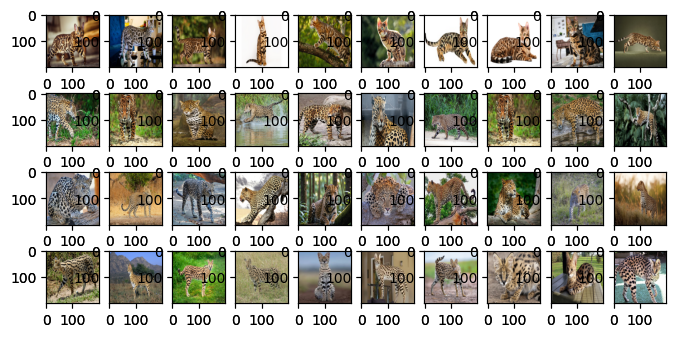

In [5]:
# Get file names
folder_e = './Fotos_einfach'
folder_h = './Fotos_schwierig'
#image_names, categories = read_image_names(filepath)
categories_e, image_names_e, labels_e = func.get_filenames_labels(folder_e)
categories_h, image_names_h, labels_h = func.get_filenames_labels(folder_h)
print(image_names_e)
print(labels_e)
print(categories_e)
print(image_names_h)
print(labels_h)
print(categories_h)
# Load images
input_shape = {
    "height": 200,
    "width": 200,
    "channels": 3
}
images_e = func.read_images(image_names_e, height=input_shape["height"], width=input_shape["width"])
images_h = func.read_images(image_names_h, height=input_shape["height"], width=input_shape["width"])
# Convert images to array
aimages_e = func.images_to_array(images_e)
aimages_h = func.images_to_array(images_h)
print(f'Shape of images array: {aimages_e.shape}')
# Plot images array
fig = plt.figure(figsize=(8, 8))
rows, columns = 8, 10
for i in range(aimages_h.shape[0]):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(aimages_h[i, ...])
plt.show()


#### Data Augmentation

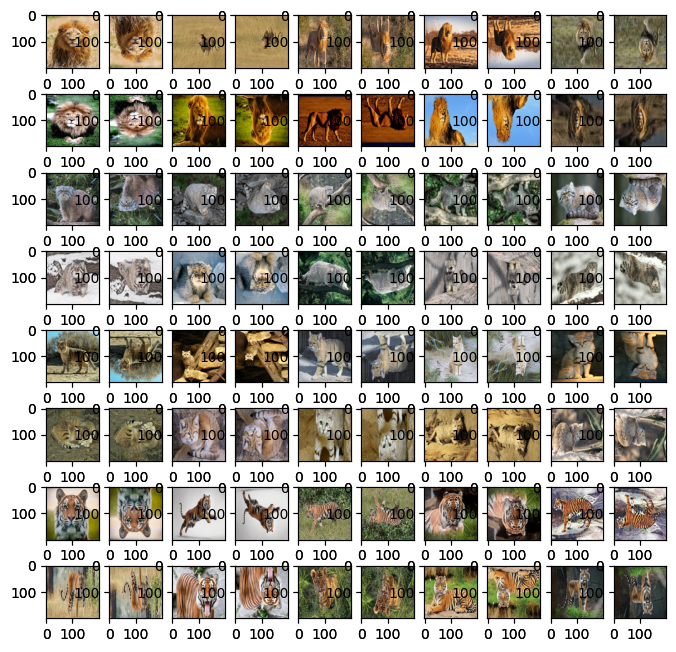

['bengal' 'bengal' 'bengal' 'bengal' 'bengal' 'bengal' 'bengal' 'bengal'
 'bengal' 'bengal' 'bengal' 'bengal' 'bengal' 'bengal' 'bengal' 'bengal'
 'bengal' 'bengal' 'bengal' 'bengal' 'jaguar' 'jaguar' 'jaguar' 'jaguar'
 'jaguar' 'jaguar' 'jaguar' 'jaguar' 'jaguar' 'jaguar' 'jaguar' 'jaguar'
 'jaguar' 'jaguar' 'jaguar' 'jaguar' 'jaguar' 'jaguar' 'jaguar' 'jaguar'
 'leopard' 'leopard' 'leopard' 'leopard' 'leopard' 'leopard' 'leopard'
 'leopard' 'leopard' 'leopard' 'leopard' 'leopard' 'leopard' 'leopard'
 'leopard' 'leopard' 'leopard' 'leopard' 'leopard' 'leopard' 'serval'
 'serval' 'serval' 'serval' 'serval' 'serval' 'serval' 'serval' 'serval'
 'serval' 'serval' 'serval' 'serval' 'serval' 'serval' 'serval' 'serval'
 'serval' 'serval' 'serval']


In [17]:
def augment_images(images, labels):
    aug_images = []
    aug_labels = []
    for i, row in enumerate(images):
        aug_images.append(images[i])
        aug_labels.append(labels[i])
        aug_images.append(np.flipud(row))
        aug_labels.append(labels[i])
    return aug_images, aug_labels

a_images_e, a_labels_e = augment_images(aimages_e, labels_e)
aug_images_e = func.images_to_array(a_images_e)
aug_labels_e = func.images_to_array(a_labels_e)
a_images_h, a_labels_h = augment_images(aimages_h, labels_h)
aug_images_h = func.images_to_array(a_images_h)
aug_labels_h = func.images_to_array(a_labels_h)

fig = plt.figure(figsize=(8, 8))
rows, columns = 8, 10
for i in range(aug_images_h.shape[0]):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(aug_images_h[i, ...])
for i in range(aug_images_e.shape[0]):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(aug_images_e[i, ...])
plt.show()
print(aug_labels_h)

Encode Labels

In [11]:
encoder = OneHotEncoder(categories=[categories_e], sparse_output=False)
y_e = encoder.fit_transform(np.array(aug_labels_e).reshape(-1,1))
print(y_e)
encoder = OneHotEncoder(categories=[categories_h], sparse_output=False)
y_h = encoder.fit_transform(np.array(aug_labels_h).reshape(-1,1))
print("neues Array")
print(y_h)

[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0.

Training and Test-Split with K-Fold (vielleicht K-Fold auch später, unsicher bei Reihenfolge tbh)

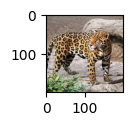

[1. 0. 0. 0.]
[0. 1. 0. 0.]


In [18]:
data_e = aug_images_e
data_h = aug_images_h
k = 4
image_folds_e, y_folds_e = func.slice_data_in_folds(data_e, y_e, k)
image_folds_h, y_folds_h = func.slice_data_in_folds(data_h, y_h, k)
fig = plt.figure(figsize=(2, 1))
plt.imshow(image_folds_e[3][2])
plt.imshow(image_folds_h[3][2])
plt.show()
print(y_folds_e[3][2])
print(y_folds_h[3][2])

#### Build Model

easy difficulty

In [8]:
epoch = 15
eval_accuracy = []
accuracy = []
for i in range(k):
    fold_x_train = np.concatenate([image_folds_e[j] for j in range(k) if j != i], axis=0)
    fold_y_train = np.concatenate([y_folds_e[j] for j in range(k) if j != i], axis=0)
    fold_x_val = image_folds_e[i]
    fold_y_val = y_folds_e[i]
    model, model_accuracy = func.build_model(epoch, fold_x_train, fold_y_train, fold_x_val, fold_y_val, input_shape, y_e)
    eval_accuracy.append(model_accuracy)
    accuracy.append(max(model.history['accuracy']))
print(eval_accuracy)
print(accuracy)

Epoch 1/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.2708 - loss: 3440.8040
Epoch 2/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.3354 - loss: 2234.4482
Epoch 3/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.3049 - loss: 335.7983
Epoch 4/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.2833 - loss: 95.8530 
Epoch 5/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.2715 - loss: 24.9964
Epoch 6/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.4764 - loss: 8.6153
Epoch 7/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.3174 - loss: 4.1086
Epoch 8/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.4569 - loss: 2.5560
Epoch 9/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.5340 - loss: 1.7679
Epoch 10/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.7812 - loss: 0.5992
Epoch 11/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.7069 - loss: 0.7318
Epoch 12/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.7500 - loss: 0.6500
Epoch 13/15
2/

Plotting of Accuracy and Loss

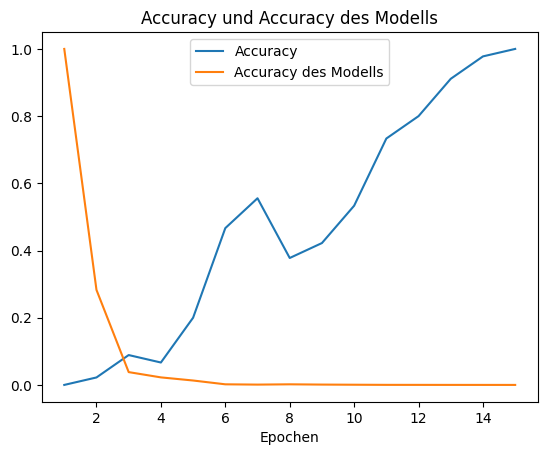

In [9]:
# noch zu überarbeiten
def minmax(a):
    a = np.asarray(a)
    a = (a - a.min()) / (a.max() - a.min())
    return a

plt.plot(range(1, epoch+1), minmax(model.history['accuracy']))
plt.plot(range(1, epoch+1), minmax(model.history['loss']))
plt.title('Accuracy und Accuracy des Modells')
plt.xlabel('Epochen')
plt.gca().legend(('Accuracy', 'Accuracy des Modells'))
plt.show()

hard difficulty

In [ ]:
epoch = 15
eval_accuracy = []
accuracy = []
for i in range(k):
    fold_x_train = np.concatenate([image_folds_h[j] for j in range(k) if j != i], axis=0)
    fold_y_train = np.concatenate([y_folds_h[j] for j in range(k) if j != i], axis=0)
    fold_x_val = image_folds_h[i]
    fold_y_val = y_folds_h[i]
    model, model_accuracy = func.build_model(epoch, fold_x_train, fold_y_train, fold_x_val, fold_y_val, input_shape, y_h)
    eval_accuracy.append(model_accuracy)
    accuracy.append(max(model.history['accuracy']))
print(eval_accuracy)
print(accuracy)

Prediction

In [ ]:
#prediction here